# The Simpsons Colorization Model


Instructions are provided below for finetuning the InstructPix2Pix model for Simpsons-style colorization

## Finetuning
(requires a CUDA GPU runtime due to Stable Diffusion requirements)

Install the correct dependencies and log in to HuggingFace with a WRITE access token.

In [ ]:
%cd finetuning
!pip install -r requirements.txt

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Environment variables may not work, so you may need to change the values of the arguments in the prompt directly. If you would not like to push to HuggingFace, remove the --push_to_hub argument. You may also try different values of the different parameters including the image resolution, random seed, and precision.

In [ ]:
!export MODEL_ID="timbrooks/instruct-pix2pix"
!export DATASET_ID="wid4soe/182_simpsons"
!export OUTPUT_DIR="ip2p-simpsons"

!accelerate launch --mixed_precision="fp16" ft_instruct_pix2pix.py \
  --pretrained_model_name_or_path="timbrooks/instruct-pix2pix" \
  --dataset_name="wid4soe/182_simpsons_train" \
  --use_ema \
  --resolution=256 --random_flip \
  --train_batch_size=2 --gradient_accumulation_steps=4 --gradient_checkpointing \
  --max_train_steps=1000 \
  --checkpointing_steps=300 --checkpoints_total_limit=1 \
  --learning_rate=5e-05 --lr_warmup_steps=0 \
  --mixed_precision=fp16 \
  --val_image_url="https://datasets-server.huggingface.co/assets/wid4soe/182_3/--/f33bb01840d693bfdb02485894413633d62531a1/--/default/train/0/original_image/image.jpg" \
  --validation_prompt="Color in the style of the Simpsons: a man in a suit and tie, with a woman in a suit and tie" \
  --seed=42 \
  --output_dir="ip2p-simpsons" \
  --report_to=tensorboard \
  --push_to_hub

## Using the model for image colorization
(Requires CUDA GPU due to Stable Diffusion requirements)

Install required dependencies:

In [ ]:
!pip install diffusers accelerate safetensors transformers

Initialize the pipeline

In [ ]:
import pandas as pd
from PIL import Image, ImageEnhance
from io import BytesIO
from IPython.display import display
import random
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "wid4soe/ip2p-simpsons" # or your local model path
pipe_simp = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe_simp.to("cuda")
pipe_simp.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_simp.scheduler.config)

Example colorization on test image

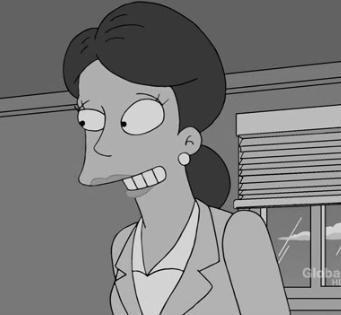

In [14]:
from PIL import ImageOps
import requests

# Convert image to greyscale
url = "https://datasets-server.huggingface.co/cached-assets/wid4soe/182_simpsons_train/--/fdf5f611397cd6a66d24a1e60f863629eb5c8da5/--/default/test/6/original_image/image.jpg"
img=Image.open(requests.get(url, stream=True).raw) # replace url with your image url or remove request.get(...) and replace with a local image path
text = "a woman in a purple suit"
img = ImageOps.grayscale(img)
img = img.convert('RGB')
img

  0%|          | 0/10 [00:00<?, ?it/s]

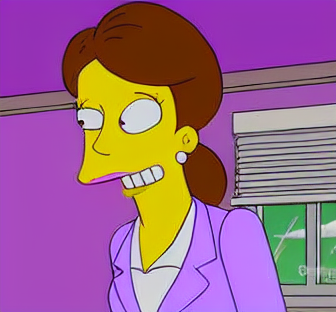

In [15]:
# Use model to generate colorized image with given prompt
prompt = "Color in the style of the Simpsons: " + text
images = pipe_simp(prompt, image=img, num_inference_steps=10, image_guidance_scale=1).images
img.save("img_mono.jpg")
images[0].save("img_color.jpg")
images[0]